In [0]:
!pip install tensorflow

In [0]:
!pip install torch
!pip install torchvision
!pip install tensorflow

In [0]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
from torchvision import transforms, datasets ,utils
 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count


In [0]:
import tensorflow as tf
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    
    in_cv = torch.rand((batch_size, dim))
    in_cv = in_cv * 2
    noise = in_cv - 1
  
    return noise



In [0]:
sample_noise(2,10)

tensor([[-0.4465, -0.2031, -0.2290, -0.0350, -0.0555, -0.2838, -0.3964,  0.1732,
         -0.6537, -0.0522],
        [-0.3824,  0.1670,  0.9568,  0.2346,  0.6299,  0.2839,  0.0284,  0.0943,
          0.8924, -0.7889]])

Make sure noise is the correct shape and type:

Processing...
Done!


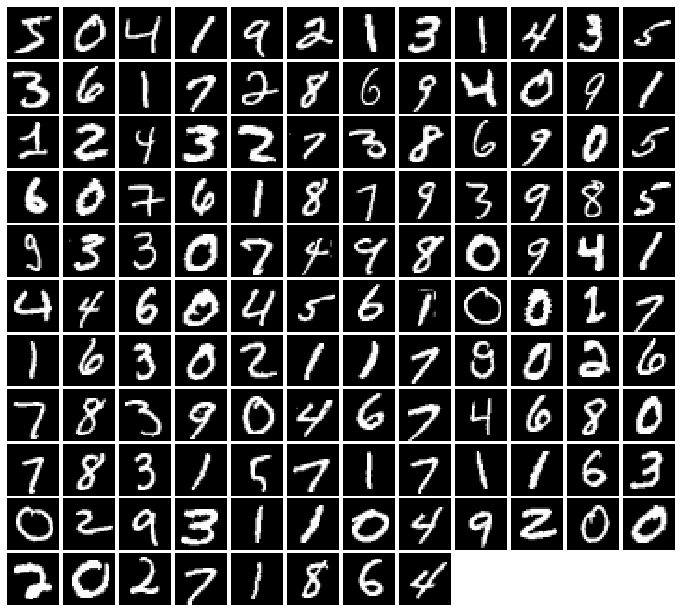

In [0]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 100
batch_size = 128

mnist_train = dset.MNIST('./data/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./data/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

In [0]:
# dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!


#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* 36 Filters, 4x4, Stride 1, Leaky ReLU(alpha=0.02)
* Max Pool 2x2, Stride 2
* 72 Filters, 4x4, Stride 1, Leaky ReLU(alpha=0.02)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected output size 1024, Leaky ReLU(alpha=0.02)
* Fully Connected output size 1

In [0]:
def build_dc_classifier():#mnist
  
    return nn.Sequential(
        Unflatten(C=1, H = 28, W = 28), #1 * 28 * 28
        nn.Conv2d(1, 36, kernel_size=(4,4), stride=1), # 36 x 25 x 25
        nn.LeakyReLU(negative_slope=0.02),
        nn.MaxPool2d(2, stride=2), # 36 * 12 * 12
        nn.Conv2d(36, 72, kernel_size=4, stride=1), #72 x 9 x 9
        nn.LeakyReLU(negative_slope=0.02),
        nn.MaxPool2d(2, stride=2), # 72 x 4 x 4
        Flatten(),
        nn.Linear(1152, 1024),
        nn.LeakyReLU(negative_slope=0.02),
        nn.Linear(1024, 1),
    )

In [0]:
build_dc_classifier()

Sequential(
  (0): Unflatten()
  (1): Conv2d(1, 36, kernel_size=(4, 4), stride=(1, 1))
  (2): LeakyReLU(negative_slope=0.02)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(36, 72, kernel_size=(4, 4), stride=(1, 1))
  (5): LeakyReLU(negative_slope=0.02)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Flatten()
  (8): Linear(in_features=1152, out_features=1024, bias=True)
  (9): LeakyReLU(negative_slope=0.02)
  (10): Linear(in_features=1024, out_features=1, bias=True)
)

Check the number of parameters in your classifier as a sanity check:

#### Generator.
See the document for documentation for [ConvTranspose2d](http://pytorch.org/docs/master/nn.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d). 

* Fully connected of size 1500, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 120, ReLU
* BatchNorm
* Reshape into Image Tensor using Unflatten(), you should figure out the parameters of N,C,H and W.
* 60 ConvTranspose2d filters of 4x4, stride 2,  padding=1, ReLU
* BatchNorm
* 1 ConvTranspose2d filter of 4x4, stride 2, padding=1, TanH
* Should have a 28x28x1 image, reshape back into 784 vector

In [0]:
def build_dc_generator(noise_dim=NOISE_DIM):#mnist
    return nn.Sequential(
    
        nn.Linear(NOISE_DIM, 1500), 
        nn.ReLU(),
        nn.BatchNorm1d(1500),
        nn.Linear(1500, 5880),
        nn.ReLU(),
        nn.BatchNorm1d(5880),
        Unflatten(C = 120, H = 7, W = 7), # 120 x 7 x 7
        nn.ConvTranspose2d(120, 60, 4, 2, 1), # 60 x 14 x 14
        nn.ReLU(),
        nn.BatchNorm2d(60),
        nn.ConvTranspose2d(60, 1, 4, 2, 1), # 1 x 28 x 28
        nn.Tanh(),
        Flatten()
    ).cuda()

Check the number of parameters in your generator as a sanity check:

In [0]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()



In [0]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    
#     print(logits_real.shape)
    true_shape = logits_real.shape[0];
    fake_shape = logits_fake.shape[0];
    encourage you
    true_labels = Variable(torch.ones(true_shape)).type(dtype)
    fake_labels = Variable(torch.zeros(fake_shape)).type(dtype)
    first_term = bce_loss(logits_real, true_labels)
    second_term = bce_loss(logits_fake, fake_labels)
    loss = (true_shape * first_term + fake_shape * second_term) / (true_shape + fake_shape)

    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """

    loss= bce_loss(logits_fake, Variable(torch.ones(logits_fake.shape[0])).type(dtype))
  
    return loss

In [0]:

def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 2e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3,  betas=(0.5, 0.999))
  
    return optimizer

In [0]:
import time
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=100, num_epochs=10):
    """
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    t1=time.time()
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            t2=time.time()
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            real_data=real_data.view(batch_size,1,784)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)
            fake_images=fake_images.detach()
            
            logits_fake = D(fake_images.view(batch_size, 1, 784))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 784))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data,g_error.data))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print('total time: %.2f'%(time.time()-t1))
                print('100 iter time: %.2f'%(time.time()-t2))
                print()
            iter_count += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


start training
Iter: 0, D: 0.6841, G:0.3165


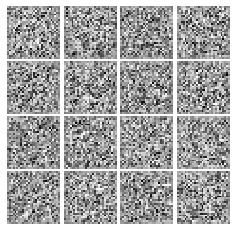

total time: 1.12
100 iter time: 1.11

Iter: 250, D: 0.725, G:0.8652


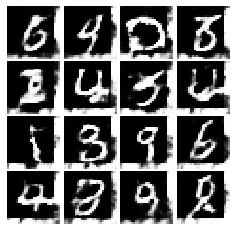

total time: 16.18
100 iter time: 0.94

Iter: 500, D: 0.6127, G:0.9063


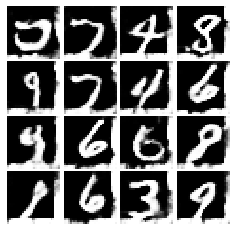

total time: 31.23
100 iter time: 1.03

Iter: 750, D: 0.5971, G:0.7803


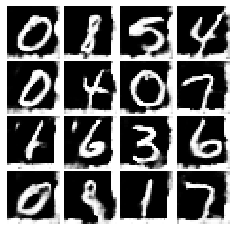

total time: 46.24
100 iter time: 0.94

Iter: 1000, D: 0.679, G:0.9756


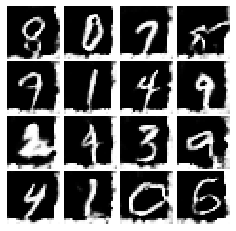

total time: 61.29
100 iter time: 1.03

Iter: 1250, D: 0.6536, G:0.9559


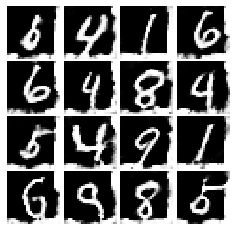

total time: 76.26
100 iter time: 0.94

Iter: 1500, D: 0.6826, G:0.7328


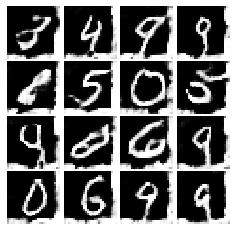

total time: 91.35
100 iter time: 1.06

Iter: 1750, D: 0.6286, G:0.8332


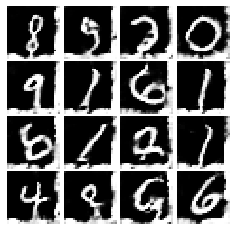

total time: 106.30
100 iter time: 0.93

Iter: 2000, D: 0.6792, G:0.7857


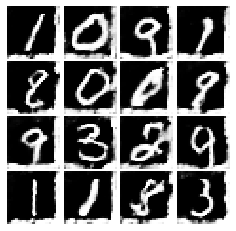

total time: 121.26
100 iter time: 0.94

Iter: 2250, D: 0.6226, G:0.8822


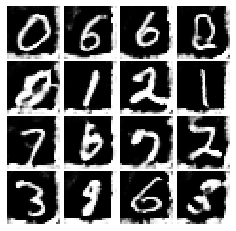

total time: 136.34
100 iter time: 1.07

Iter: 2500, D: 0.627, G:1.535


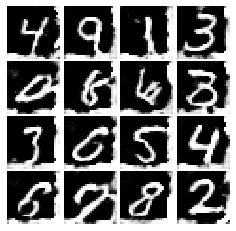

total time: 151.32
100 iter time: 0.93

Iter: 2750, D: 0.5402, G:1.491


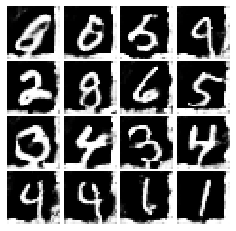

total time: 166.38
100 iter time: 1.03

Iter: 3000, D: 0.4955, G:0.8113


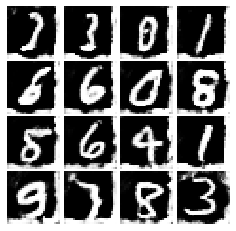

total time: 181.35
100 iter time: 0.94

Iter: 3250, D: 0.4284, G:1.448


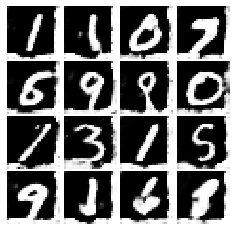

total time: 196.41
100 iter time: 1.03

Iter: 3500, D: 0.434, G:1.411


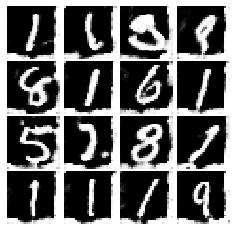

total time: 211.36
100 iter time: 0.92

Iter: 3750, D: 0.4011, G:1.149


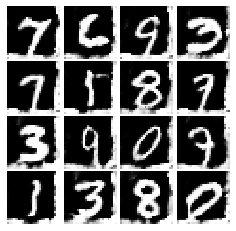

total time: 226.40
100 iter time: 1.01

Iter: 4000, D: 0.4273, G:2.345


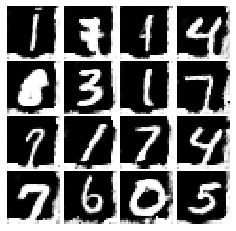

total time: 241.33
100 iter time: 0.92

Iter: 4250, D: 0.3004, G:1.869


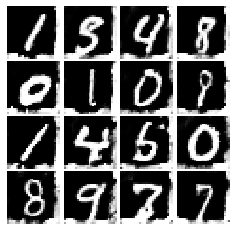

total time: 256.37
100 iter time: 1.03

Iter: 4500, D: 0.3835, G:2.69


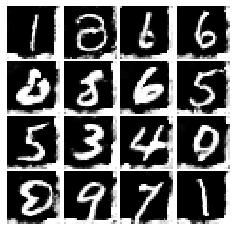

total time: 271.31
100 iter time: 0.93

Iter: 4750, D: 0.6773, G:2.33


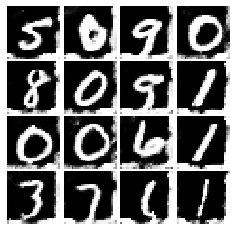

total time: 286.24
100 iter time: 0.91

Iter: 5000, D: 0.3169, G:2.761


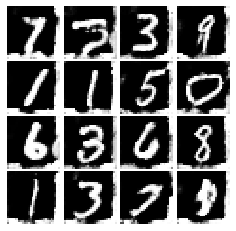

total time: 301.28
100 iter time: 1.03

Iter: 5250, D: 0.3014, G:1.989


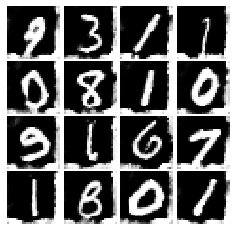

total time: 316.22
100 iter time: 0.93

Iter: 5500, D: 0.3694, G:2.817


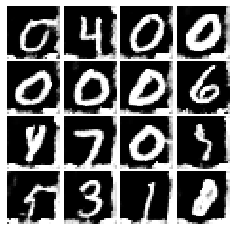

total time: 331.25
100 iter time: 1.01

Iter: 5750, D: 0.2612, G:2.434


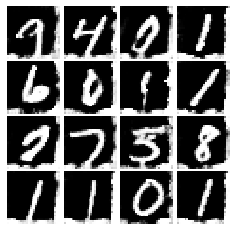

total time: 346.16
100 iter time: 0.90

Iter: 6000, D: 0.316, G:1.74


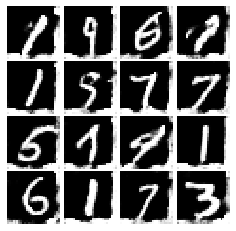

total time: 361.19
100 iter time: 1.01

Iter: 6250, D: 0.4678, G:4.023


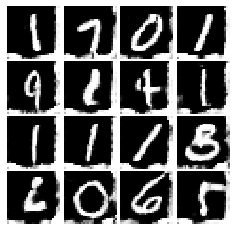

total time: 376.16
100 iter time: 0.94

Iter: 6500, D: 0.263, G:3.018


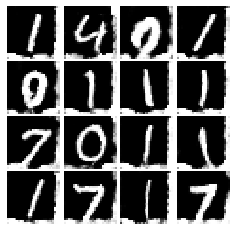

total time: 391.18
100 iter time: 1.01

Iter: 6750, D: 0.1826, G:3.03


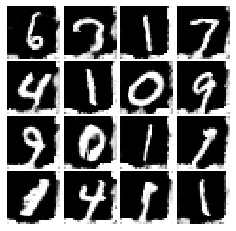

total time: 406.08
100 iter time: 0.89

Iter: 7000, D: 0.2786, G:3.099


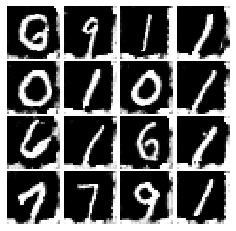

total time: 421.09
100 iter time: 1.01

Iter: 7250, D: 0.2387, G:2.788


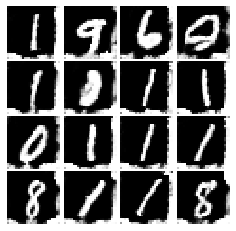

total time: 436.03
100 iter time: 0.92

Iter: 7500, D: 0.1926, G:2.33


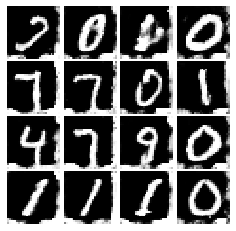

total time: 450.92
100 iter time: 0.91

Iter: 7750, D: 0.2147, G:3.581


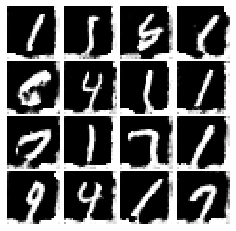

total time: 465.90
100 iter time: 1.00

Iter: 8000, D: 0.1633, G:3.21


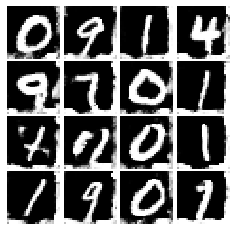

total time: 480.87
100 iter time: 0.98

Iter: 8250, D: 0.1563, G:3.424


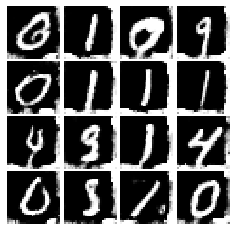

total time: 495.87
100 iter time: 0.98

Iter: 8500, D: 0.2398, G:4.322


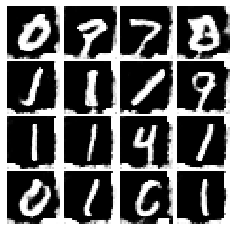

total time: 510.76
100 iter time: 0.91

Iter: 8750, D: 0.1559, G:2.647


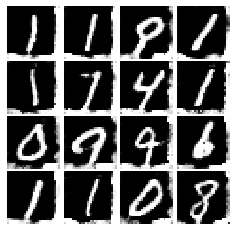

total time: 525.77
100 iter time: 1.00

Iter: 9000, D: 0.1743, G:2.893


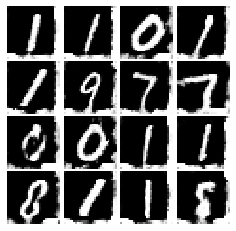

total time: 540.68
100 iter time: 0.90

Iter: 9250, D: 0.1235, G:3.93


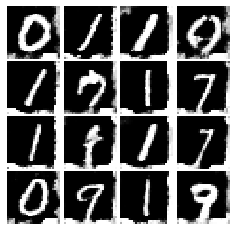

total time: 555.68
100 iter time: 1.01

Iter: 9500, D: 0.1512, G:3.671


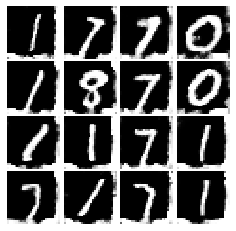

total time: 570.62
100 iter time: 0.91

Iter: 9750, D: 0.1607, G:4.094


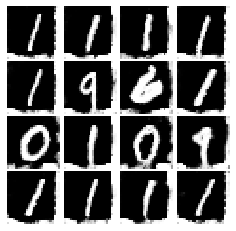

total time: 585.70
100 iter time: 1.07

Iter: 10000, D: 0.1447, G:4.158


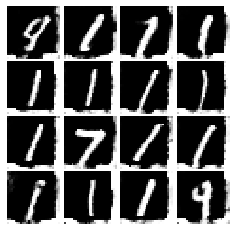

total time: 600.61
100 iter time: 0.91

Iter: 10250, D: 0.1022, G:3.925


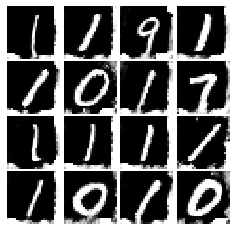

total time: 615.53
100 iter time: 0.90

Iter: 10500, D: 0.1235, G:3.477


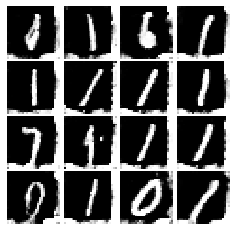

total time: 630.54
100 iter time: 1.02

Iter: 10750, D: 0.0903, G:4.431


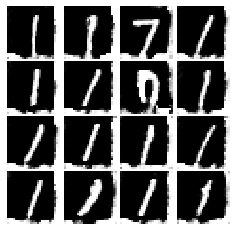

total time: 645.46
100 iter time: 0.90

Iter: 11000, D: 0.08236, G:4.588


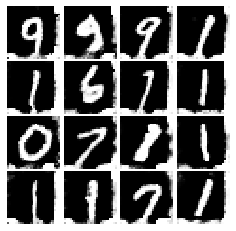

total time: 660.44
100 iter time: 0.99

Iter: 11250, D: 0.1054, G:5.037


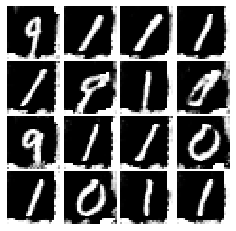

total time: 675.32
100 iter time: 0.90

Iter: 11500, D: 0.08879, G:4.482


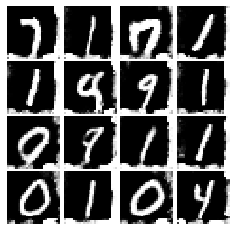

total time: 690.34
100 iter time: 1.02

Iter: 11750, D: 0.04582, G:4.871


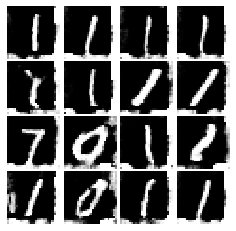

total time: 705.25
100 iter time: 0.89

Iter: 12000, D: 0.1061, G:3.989


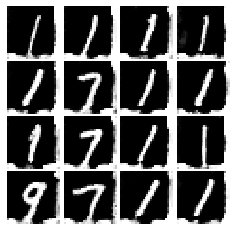

total time: 720.23
100 iter time: 1.01

Iter: 12250, D: 0.08029, G:3.995


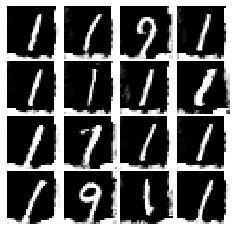

total time: 735.14
100 iter time: 0.89

Iter: 12500, D: 0.08444, G:5.181


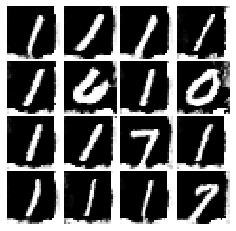

total time: 750.17
100 iter time: 1.05

Iter: 12750, D: 0.12, G:4.209


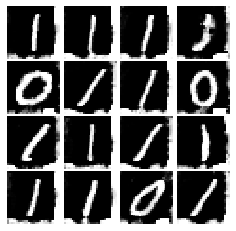

total time: 765.06
100 iter time: 0.90

Iter: 13000, D: 0.07405, G:4.568


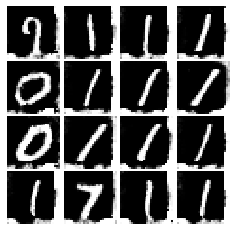

total time: 779.92
100 iter time: 0.88

Iter: 13250, D: 0.06583, G:5.823


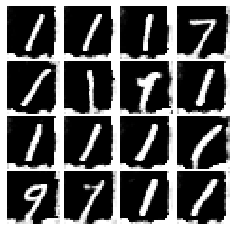

total time: 795.03
100 iter time: 1.09

Iter: 13500, D: 0.04549, G:5.197


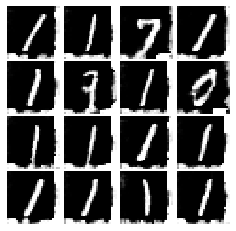

total time: 809.94
100 iter time: 0.89

Iter: 13750, D: 0.03412, G:7.31


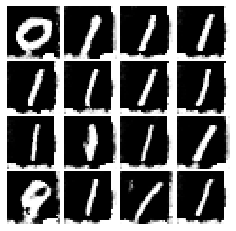

total time: 824.94
100 iter time: 1.00

Iter: 14000, D: 0.03455, G:6.085


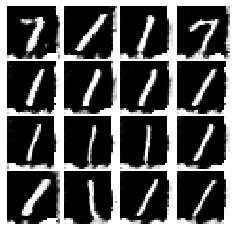

total time: 839.82
100 iter time: 0.91

Iter: 14250, D: 0.03051, G:6.318


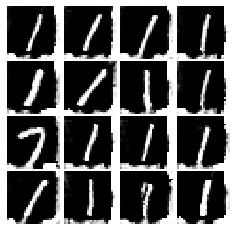

total time: 854.86
100 iter time: 1.05

Iter: 14500, D: 0.09331, G:5.582


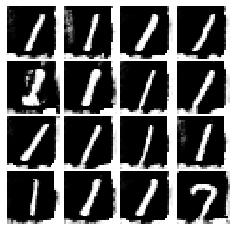

total time: 869.76
100 iter time: 0.91

Iter: 14750, D: 0.05645, G:5.98


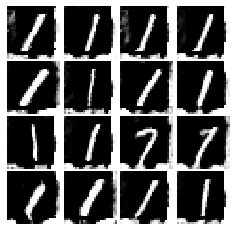

total time: 884.78
100 iter time: 1.00

Iter: 15000, D: 0.03324, G:6.941


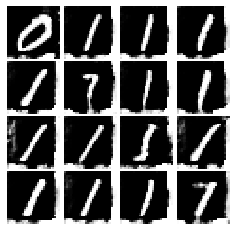

total time: 899.68
100 iter time: 0.91

Iter: 15250, D: 0.05023, G:6.157


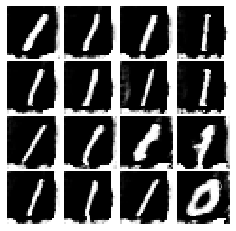

total time: 914.74
100 iter time: 1.04

Iter: 15500, D: 0.04363, G:6.143


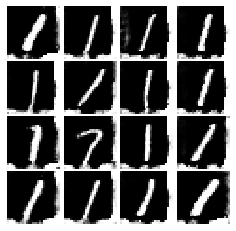

total time: 929.63
100 iter time: 0.89

Iter: 15750, D: 0.02198, G:6.531


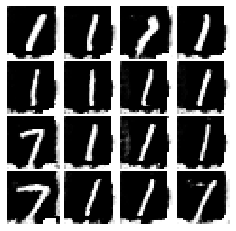

total time: 944.50
100 iter time: 0.87

Iter: 16000, D: 0.03477, G:7.699


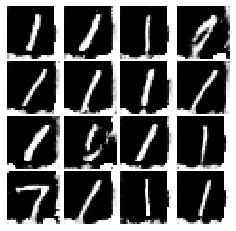

total time: 959.59
100 iter time: 1.09

Iter: 16250, D: 0.04034, G:6.74


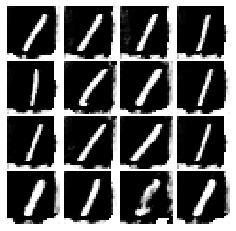

total time: 974.50
100 iter time: 0.92

Iter: 16500, D: 0.05759, G:8.608


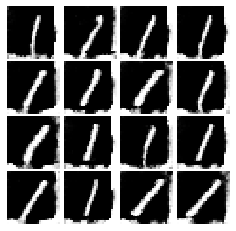

total time: 989.49
100 iter time: 1.00

Iter: 16750, D: 0.02366, G:6.466


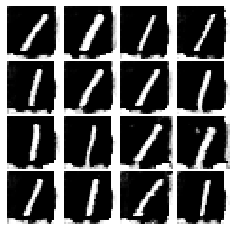

total time: 1004.40
100 iter time: 0.91

Iter: 17000, D: 0.02037, G:6.579


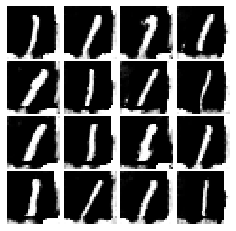

total time: 1019.38
100 iter time: 0.99

Iter: 17250, D: 0.0474, G:7.549


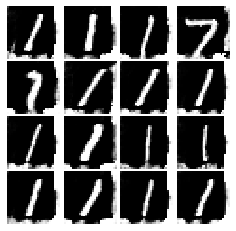

total time: 1034.28
100 iter time: 0.89

Iter: 17500, D: 0.02839, G:7.787


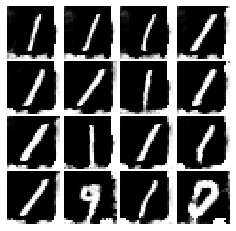

total time: 1049.27
100 iter time: 1.02

Iter: 17750, D: 0.02706, G:7.965


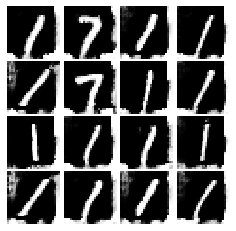

total time: 1064.19
100 iter time: 0.90

Iter: 18000, D: 0.008961, G:7.297


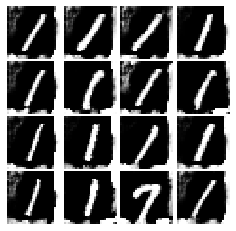

total time: 1079.19
100 iter time: 1.04

Iter: 18250, D: 0.01413, G:8.253


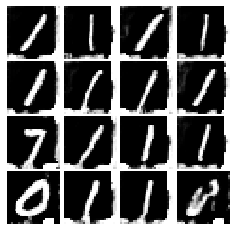

total time: 1094.07
100 iter time: 0.89

Iter: 18500, D: 0.02442, G:7.844


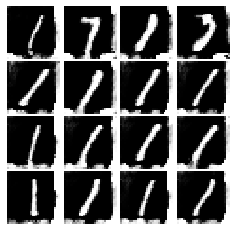

total time: 1109.03
100 iter time: 0.96

Iter: 18750, D: 0.02389, G:8.023


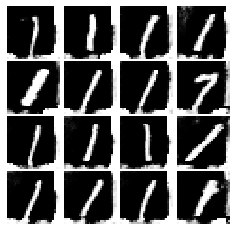

total time: 1124.06
100 iter time: 1.01

Iter: 19000, D: 0.01248, G:8.103


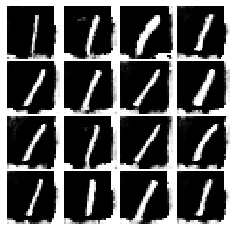

total time: 1138.92
100 iter time: 0.91

Iter: 19250, D: 0.06038, G:8.241


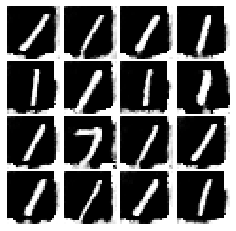

total time: 1153.88
100 iter time: 1.00

Iter: 19500, D: 0.03478, G:8.209


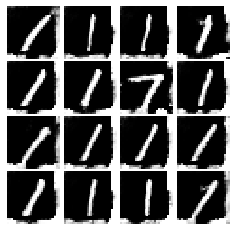

total time: 1168.77
100 iter time: 0.89

Iter: 19750, D: 0.01472, G:8.859


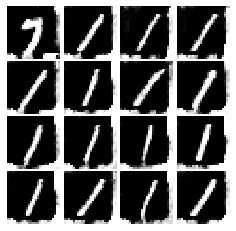

total time: 1183.82
100 iter time: 1.04

Iter: 20000, D: 0.01463, G:9.774


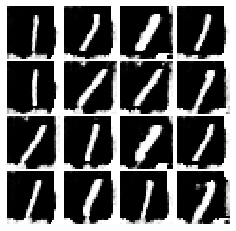

total time: 1198.70
100 iter time: 0.91

Iter: 20250, D: 0.01711, G:8.123


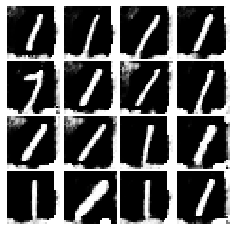

total time: 1213.71
100 iter time: 1.04

Iter: 20500, D: 0.03937, G:7.499


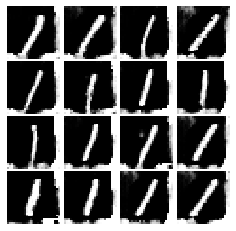

total time: 1228.61
100 iter time: 0.92

Iter: 20750, D: 0.007809, G:9.54


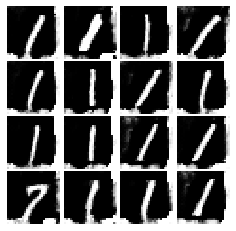

total time: 1243.50
100 iter time: 0.90

Iter: 21000, D: 0.02452, G:6.827


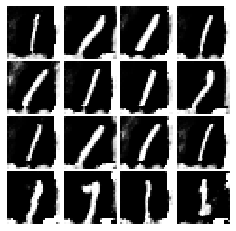

total time: 1258.47
100 iter time: 1.02

Iter: 21250, D: 0.007987, G:8.681


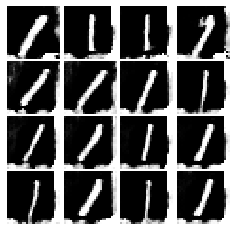

total time: 1273.35
100 iter time: 0.91

Iter: 21500, D: 0.007429, G:8.217


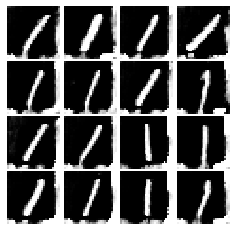

total time: 1288.36
100 iter time: 1.02

Iter: 21750, D: 0.07653, G:7.423


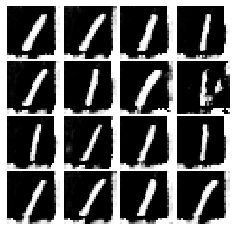

total time: 1303.24
100 iter time: 0.89

Iter: 22000, D: 0.002395, G:8.852


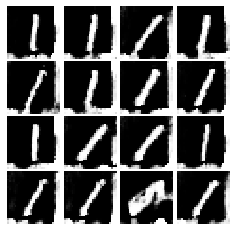

total time: 1318.22
100 iter time: 1.00

Iter: 22250, D: 0.032, G:9.226


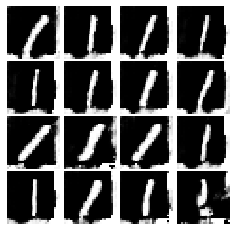

total time: 1333.07
100 iter time: 0.88

Iter: 22500, D: 0.01376, G:10.23


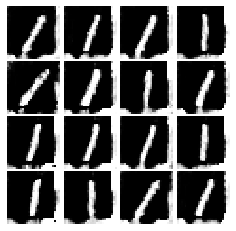

total time: 1348.03
100 iter time: 1.00

Iter: 22750, D: 0.02247, G:9.692


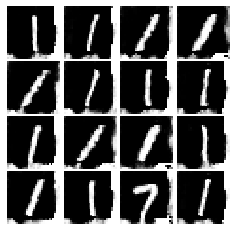

total time: 1362.92
100 iter time: 0.90

Iter: 23000, D: 0.006437, G:9.315


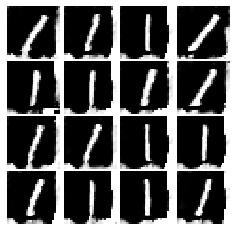

total time: 1377.89
100 iter time: 1.01

Iter: 23250, D: 0.01525, G:9.238


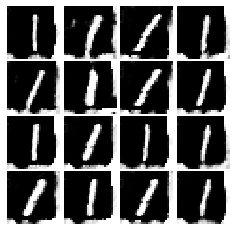

total time: 1392.76
100 iter time: 0.89

Iter: 23500, D: 0.06568, G:10.3


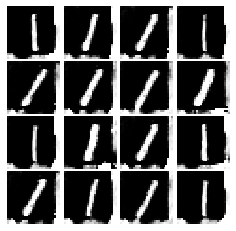

total time: 1407.60
100 iter time: 0.90

Iter: 23750, D: 0.2387, G:4.782


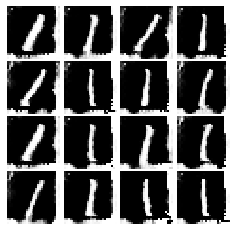

total time: 1422.60
100 iter time: 1.02

Iter: 24000, D: 0.2547, G:2.561


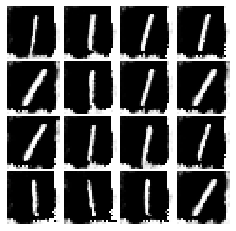

total time: 1437.43
100 iter time: 0.90

Iter: 24250, D: 0.2871, G:3.063


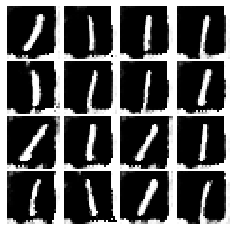

total time: 1452.36
100 iter time: 0.99

Iter: 24500, D: 0.1652, G:3.233


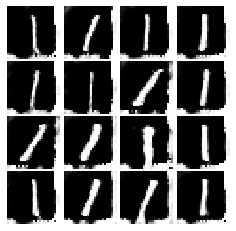

total time: 1467.20
100 iter time: 0.90

Iter: 24750, D: 0.1174, G:3.557


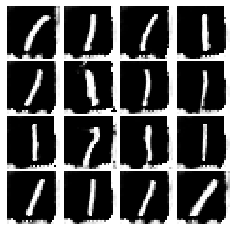

total time: 1482.24
100 iter time: 1.07

Iter: 25000, D: 0.1613, G:3.33


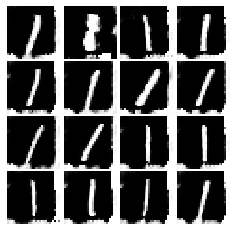

total time: 1497.10
100 iter time: 0.90

Iter: 25250, D: 0.1611, G:2.601


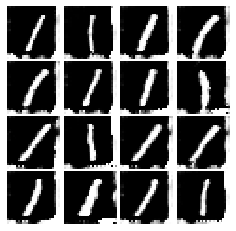

total time: 1512.07
100 iter time: 1.03

Iter: 25500, D: 0.1679, G:2.87


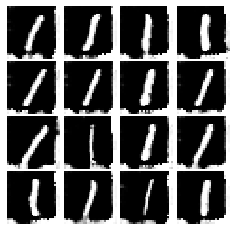

total time: 1526.97
100 iter time: 0.93

Iter: 25750, D: 0.1887, G:3.586


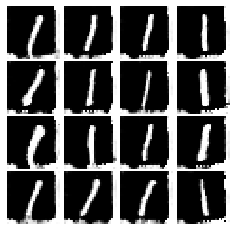

total time: 1541.87
100 iter time: 0.91

Iter: 26000, D: 0.1141, G:2.872


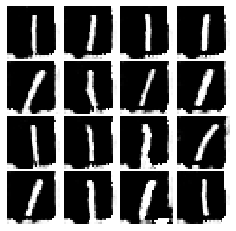

total time: 1556.87
100 iter time: 1.04

Iter: 26250, D: 0.126, G:3.288


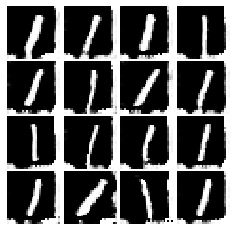

total time: 1571.74
100 iter time: 0.90

Iter: 26500, D: 0.155, G:2.601


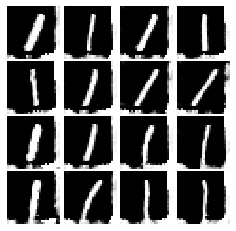

total time: 1586.71
100 iter time: 1.00

Iter: 26750, D: 0.2072, G:3.728


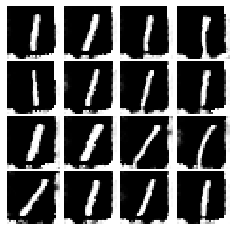

total time: 1601.58
100 iter time: 0.91

Iter: 27000, D: 0.1007, G:3.539


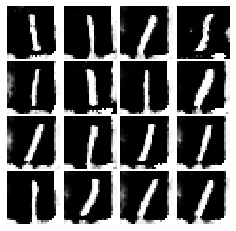

total time: 1616.49
100 iter time: 0.99

Iter: 27250, D: 0.1131, G:4.951


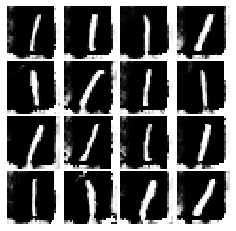

total time: 1631.30
100 iter time: 0.88

Iter: 27500, D: 0.05735, G:5.159


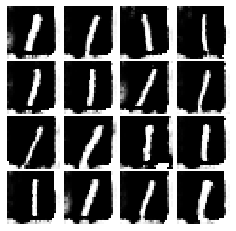

total time: 1646.26
100 iter time: 1.01

Iter: 27750, D: 0.09337, G:5.221


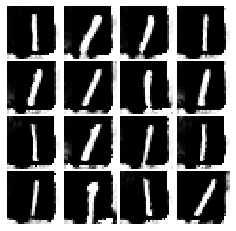

total time: 1661.11
100 iter time: 0.91

Iter: 28000, D: 0.07304, G:5.58


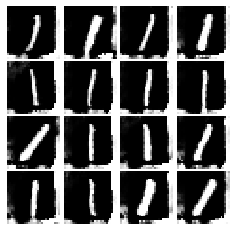

total time: 1676.04
100 iter time: 1.01

Iter: 28250, D: 0.01948, G:6.278


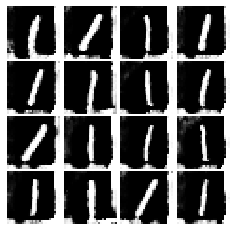

total time: 1690.89
100 iter time: 0.91

Iter: 28500, D: 0.02404, G:5.706


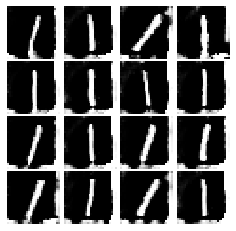

total time: 1705.71
100 iter time: 0.89

Iter: 28750, D: 0.01676, G:7.265


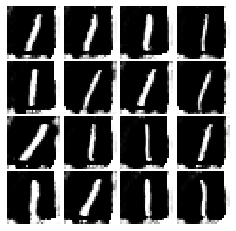

total time: 1720.75
100 iter time: 1.07

Iter: 29000, D: 0.0322, G:6.166


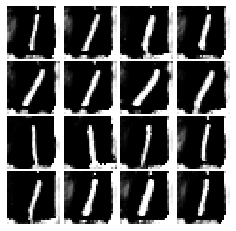

total time: 1735.65
100 iter time: 0.91

Iter: 29250, D: 0.05238, G:7.352


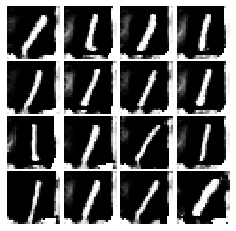

total time: 1750.58
100 iter time: 1.01

Iter: 29500, D: 0.02754, G:8.179


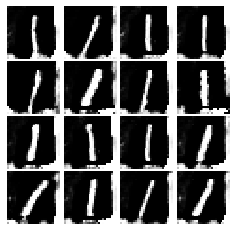

total time: 1765.43
100 iter time: 0.92

Iter: 29750, D: 0.007402, G:8.122


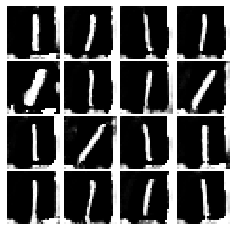

total time: 1780.37
100 iter time: 1.00

Iter: 30000, D: 0.006018, G:7.289


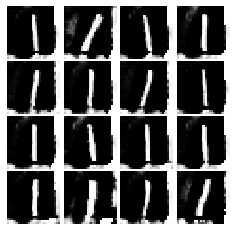

total time: 1795.20
100 iter time: 0.89

Iter: 30250, D: 0.1058, G:5.845


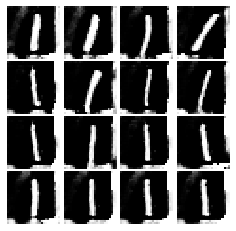

total time: 1810.18
100 iter time: 1.00

Iter: 30500, D: 0.02033, G:6.915


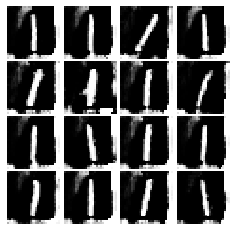

total time: 1824.99
100 iter time: 0.91

Iter: 30750, D: 0.009003, G:8.277


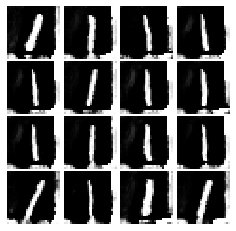

total time: 1839.96
100 iter time: 1.03

Iter: 31000, D: 0.01635, G:8.424


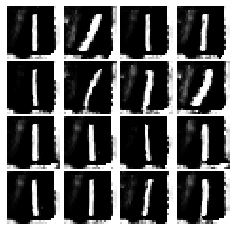

total time: 1854.80
100 iter time: 0.91

Iter: 31250, D: 0.004891, G:8.101


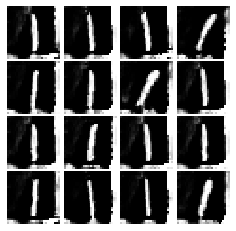

total time: 1869.63
100 iter time: 0.91



KeyboardInterrupt: ignored

In [0]:
# Make the discriminator
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
# Make the generator
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)
# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)
t1=time.time()
print('start training')
# Run it!
run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=3000)
print(time.time()-t1)